Projet réalisé par :\
Mahmoud Benboubker\
Nicolas Calligaro\
Aïcha Lalhou

# Etude Approfondie des bases 
Dans ce notebook, nous nous sommes intéressé à l'étude des bases, et donc plus particulièrement de la variable 'bsid'.

Nous avons mis en exerguue des potentielles erreurs dans la saisie de certaines données relatives à certaines bases. 

Nous avons également proposé des solutions pour pallier à ces problèmes qui sont énoncées  à la fin de ce notebook. Nous avons également intégré un description de l'algorithme qui permet de corriger le problème que nous avons identifié, qui est utilisable pour le X_train et X_test. 

NB: L'algorithme décrit est implémenté dans la fonction Correct_Bases dans le fichier IotTools.

NB2 : Dans le test on a identifié une base impossible a déplacer automatiquement. ainsi un traitement manuel sera mis en oeuvre



# Affichons toutes les bases en utilisant la bibliohtèque ipyleefleat et leur coordonnée GPS.

In [1]:
import pandas as pd
import numpy as np
from IotTools import *
from IpyTools import *
from ipyleaflet import Map, basemaps

In [2]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

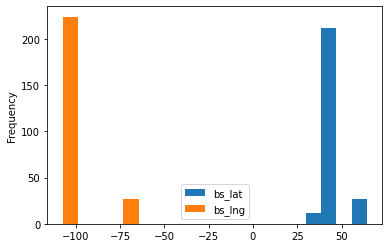

In [3]:
df_Coord_Base = df_mess_train[['bsid','bs_lat','bs_lng']].drop_duplicates(subset ='bsid', keep = 'first').set_index('bsid')
df_Coord_Base.head(1)
df_Coord_Base.plot(kind='hist',bins=20);

Conclusion : on voit qu'il y a deux groupes de bases à différentes location.
La distance entre ces deux groupes parait conséquente au vu de la zone réelle des messages considérés. 

# Affichons les deux clusters

In [4]:
df_out = df_Coord_Base[df_Coord_Base.bs_lat>64]
df_in = df_Coord_Base.drop(df_out.index)
df_out.shape,df_in.shape,df_Coord_Base.shape

((27, 2), (224, 2), (251, 2))

In [5]:
barycentre = ((df_Coord_Base.bs_lat.max()+df_Coord_Base.bs_lat.min())/2,(df_Coord_Base.bs_lng.min()+df_Coord_Base.bs_lng.max())/2)
barycentre

(50.176696843049996, -87.98157291199999)

In [6]:
m = Map(center=barycentre, zoom=3, basemap = basemaps.OpenStreetMap.Mapnik)

dot_in = Give_Marker_Cluster(df_Coord_Base)
dot_out = Give_Marker_Cluster(df_out)

m.add_layer(dot_in)
m.add_layer(dot_out)
m
#L'affichage en 'marker clustered' met en évidence que les bases sont toutes l'une sur l'autre

Map(center=[50.176696843049996, -87.98157291199999], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Conclusion : 
- Le cluster des bases au canada contient des bases à exactement la même localisation, contrairement au cluster se situant à Denver

# Question : 
Ces bases sont elles des outliers ? et donc à supprimer 
Ou des erreurs de saisie sur leurs coordonées? et donc à traiter

In [7]:
#Liste des bases reçu par un message 
a=[];b=[];c=[]
for key, elmt in df_mess_train.groupby("messid"):
    a.append(key);b.append(elmt.bsid.values);c.append(len(elmt.bsid.values))
msg_base = pd.DataFrame({'messid':a,'bsid':b,'size':c})
msg_base.set_index('messid',inplace=True)
msg_base.head(1)

,bsid,size
messid,,
573bf1d9864fce1a9af8c5c9,"[2841, 3526]",2


In [8]:
#Liste de tous les messages avec leur coordonées
pos_train['messid'] = df_mess_train.messid
msg_coord = pos_train.groupby('messid').mean()
msg_coord.head(1)

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,39.60669,-104.95849


# Voyons sur quels messages elles apparraissent et où sont ces messages

In [9]:
#Listes des bases outliers
base_out = df_out.index.values
base_out

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  1854,  7248],
      dtype=int64)

In [10]:
#1849 Messages captés par les bases outliers.
msg_out = df_mess_train[df_mess_train.bsid.isin(base_out)].messid.unique()
print(f"NB messages captés par l'une des bases outliers: {len(msg_out)}")

NB messages captés par l'une des bases outliers: 1849


# Localisation des messages

In [11]:
m = Map(center=barycentre, zoom=3, basemap = basemaps.OpenStreetMap.Mapnik)

msg_coord_out = msg_coord[msg_coord.index.isin(msg_out)]
message = Draw_Dot(msg_coord_out,'green')

for i in message :
    m.add_layer(i)
m
#msg_coord[msg_coord.index.isin(msg_out)]

Map(center=[50.176696843049996, -87.98157291199999], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Conclusion : 
- Tous les messages reçus par les bases outliers sont au même endroit.

# Ces bases ne sont pas des outliers, mais bien des erreurs de saisie nous devons donc les traiter.
> Solution 1 : Retirer les bases des données
> Solution 2 : Corriger les coordonnées par une extrapolation

# Affichons les messages et toutes les bases liées a ces bases outliers

In [12]:
msg_coord_Denvers = msg_coord_out[msg_coord_out.lat<40]
a = msg_coord_Denvers.index.values
b=msg_base[msg_base.index.isin(a)]['size'].max()
denver = msg_base[msg_base['size']==b].index.values[0]
print(f"le msg le plus capté par l'une des bases outliers à Denver : {denver}")
d = msg_base[msg_base.index== denver].bsid.values[0]
base_denver = df_Coord_Base[df_Coord_Base.index.isin(d)]


le msg le plus capté par l'une des bases outliers à Denver : 57aeb41fe541cd77a044cdb8


In [13]:
m = Map(center=barycentre, zoom=3, basemap = basemaps.OpenStreetMap.Mapnik)

m.add_layer(Give_Colored_Marker(msg_coord[msg_coord.index==denver])[0])

out_b = Give_Marker_Cluster(base_denver[base_denver.bs_lat>45])
m.add_layer(out_b)

denver_b = Draw_Dot(base_denver[base_denver.bs_lat<45],color='green')
for i in denver_b :
    m.add_layer(i)
m

Map(center=[50.176696843049996, -87.98157291199999], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [14]:
msg_coord_out_Denvers = msg_coord_out[msg_coord_out.lat>40]
a = msg_coord_out_Denvers.index.values
wyoming =msg_base[msg_base.index.isin(a)].iloc[0].name
print(f"le msg le plus capté par l'une des bases outliers au Wyoming : {wyoming}")

le msg le plus capté par l'une des bases outliers au Wyoming : 5822df26cf554f7e3aa2e56e


In [15]:
d = msg_base[msg_base.index== wyoming].bsid.values[0]
base_wyoming = df_Coord_Base[df_Coord_Base.index.isin(d)]

In [16]:
m = Map(center=barycentre, zoom=3, basemap = basemaps.OpenStreetMap.Mapnik)

m.add_layer(Give_Colored_Marker(msg_coord[msg_coord.index==wyoming])[0])

out_b = Give_Marker_Cluster(base_wyoming[base_wyoming.bs_lat>45])
m.add_layer(out_b)

denver_b = Draw_Dot(base_wyoming[base_wyoming.bs_lat<45],color='green')
for i in denver_b :
    m.add_layer(i)
m

Map(center=[50.176696843049996, -87.98157291199999], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Conclusion :
- Les messages sont captés par un ensemble cohérent de base 
- Les bases au Canada sont bien des erreurs de saisie
- Il nous reste à vérifier qu'une meme base au canada n'est pas capté par un msg au wyoming et un autre dans denver

# Question : Est ce que les bases outliers vu à Denvers sont les mêmes que celle vu au Wyoming ?

In [17]:
a = msg_coord_out[msg_coord_out.lat<40].index.values;a
tmp=[]
for _,row in msg_base[msg_base.index.isin(a)].iterrows():
    tmp.extend(row.bsid)
e = set(df_out[df_out.index.isin(tmp)].index.values);len(e)
df_out[df_out.index.isin(tmp)].index.values

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123,  1092,  1854,  7248], dtype=int64)

In [18]:
b = msg_coord_out[msg_coord_out.lat>40].index.values;b
tmp=[]
for _,row in msg_base[msg_base.index.isin(b)].iterrows():
    tmp.extend(row.bsid)
f = set(df_out[df_out.index.isin(tmp)].index.values);len(f)
df_out[df_out.index.isin(tmp)].index.values

array([11951,  9784], dtype=int64)

In [19]:
print(f" Les deux listes sont rigoureusement différente : {set(e)-set(f) == set(e)}")
#On voit que toutes les bases outliers sont capté par des messages dans des sites différents 

 Les deux listes sont rigoureusement différente : True


# Conclusion : 
- Ces bases sont distinctes et liées de façon cohérente au reste de la base de données 
- Nous allons mettre en oeuvre un algo qui va corriger les bases sur le train ET le test.

## Algo : pour corriger les coordonnées de ces bases outliers :

1- Identifier les bases Outliers\
2- Identifier les messages étant captés par ces bases\
3- Produire le DataFrame avec des messages mais sans les bases\
4- Calculer le BaryCentre pondéré de tous les messages\
5- Dans le DataFrame principal, pour chaque base, prendre la moyenne de tous les BaryCentres calculés\
6- Mettre à jour les coordonées avec ce point

In [20]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_Coord_Base = df_mess_train[['bsid','bs_lat','bs_lng']].drop_duplicates(subset ='bsid', keep = 'first').set_index('bsid')

df_out = df_Coord_Base[df_Coord_Base.bs_lat>64]
base_in = df_mess_train[df_mess_train.bs_lat<64].bsid.unique()
base_out = df_out.index.values
msg_out = df_mess_train[df_mess_train.bsid.isin(base_out)].messid.unique()


In [21]:
old_coord_base_outliers = df_mess_train[df_mess_train.bsid.isin(base_out)][['bsid','bs_lat','bs_lng']].drop_duplicates(subset ='bsid', keep = 'first').set_index('bsid')

In [22]:
#Toutes les bases outliers a repositionner
base_out.shape

(27,)

In [23]:
#Tous les messages étant capté par ces bases
msg_out.shape

(1849,)

In [24]:
#Le DataFrame avec que les messages capté par les bases outliers ET sans les bases outliers
df_mess_out = df_mess_train[(df_mess_train.messid.isin(msg_out))&(~df_mess_train.bsid.isin(base_out))]

In [25]:
messid=[];coordW=[]
group = df_mess_out.groupby('messid')

for i in group.groups:
    tmp=group.get_group(i)
    rssi_reshape= (10**(tmp.rssi.values/10))
    latW = tmp.bs_lat.values * rssi_reshape
    lngW = tmp.bs_lng.values * rssi_reshape
    messid.append(tmp.messid.unique()[0])
    coordW.append((latW.sum()/rssi_reshape.sum(),lngW.sum()/rssi_reshape.sum()))
msg_coordW = pd.DataFrame(data=coordW,index=messid,columns =['lat','lng'])
#On a le barycentre de chaque message (sans tenir compte des bases outliers)
msg_coordW.shape

(1699, 2)

In [26]:
#tous ces messages ne sont capté uniquement par les bases outliers
df_clean =df_mess_train.drop(df_mess_train[~df_mess_train.messid.isin(df_mess_train[df_mess_train.bsid.isin(df_in.index.values)].messid.unique())].index)
df_clean.shape

(39082, 8)

In [27]:
bsid=[];coord=[]
group = df_clean[df_clean.bsid.isin(base_out)].groupby('bsid')
for i in group.indices:
    bsid.append(i)
    coord.append((msg_coordW.loc[group.get_group(i).messid.values].lat.mean(),msg_coordW.loc[group.get_group(i).messid.values].lng.mean()))
bsid_relocated=pd.DataFrame(data=coord,index=bsid,columns =['lat','lng'])

In [28]:
for i in bsid_relocated.index:
    df_mess_train.loc[df_mess_train.index[df_mess_train.bsid==i],'bs_lat']=bsid_relocated.loc[i].lat
    df_mess_train.loc[df_mess_train.index[df_mess_train.bsid==i],'bs_lng']=bsid_relocated.loc[i].lng

In [29]:
check = df_mess_train[df_mess_train.bsid.isin(base_out)][['bsid','bs_lat','bs_lng']].drop_duplicates(subset ='bsid', keep = 'first').set_index('bsid')

In [30]:
m = Map(center=barycentre, zoom=3, basemap = basemaps.OpenStreetMap.Mapnik)

denver = Draw_Dot(old_coord_base_outliers,color='red')
for i in denver:
    m.add_layer(i)


denver_b = Draw_Dot(check,color='green')
for i in denver_b :
    m.add_layer(i)
m

Map(center=[50.176696843049996, -87.98157291199999], controls=(ZoomControl(options=['position', 'zoom_in_text'…